<a href="https://colab.research.google.com/github/mahalingamagesthian/learningai/blob/main/8_AgenticRAG_WebDocument.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overall Flow of Your RAG Agent (The Robot's Day):
  1. `Start`
  2. **Decide** `(generate_query_or_respond):` The robot looks at the user's request and decides: "Do I need to look something up (using `retrieve_blog_posts`) or can I just answer directly?"
     * If **Direct Answer**: The robot gives the answer and stops.
     * If **Retrieve**: The robot proceeds to search.
  3. **Search** `(retrieve)`: The robot uses its `retrieve_blog_posts` skill to search your knowledge base (Lilian Weng's blog posts).
  4. **Grade** `(grade_documents)`: The robot looks at the search results and decides: "Are these results actually useful and relevant to the user's question?"
     * If **Relevant**: The robot proceeds to generate an answer.
     * If **Not Relevant**: The robot realizes its search wasn't good. It then tries to rephrase the original question to make it better.
  5. **Rewrite Question** (`rewrite_question`): The robot rephrases the question.
  6. **Loop Back:** The robot goes back to the `"Decide"` step (step 2), but now with the new, refined question in its memory. It will try searching again with the better question.
  7. **Generate Answer** (`generate_answer`): If the search results were relevant, the robot uses them to formulate a concise answer.
  8. **End**: The robot has provided its answer and is done for this turn.

  This sophisticated graph allows your RAG agent to be dynamic, self-correcting, and resilient, ensuring it provides accurate answers by intelligently leveraging its knowledge base!

# Core Concepts First:
  * `Graph`: A collection of nodes (steps/functions) and edges (transitions) that define a workflow.
  * `State`: The shared "memory" that gets passed from one node to the next. In your case, it's `MessagesState`, meaning the core shared memory is a list of conversational messages.
  * `Node`: A single step in the workflow. It's a Python function (like `generate_query_or_respond`, `rewrite_question`, `generate_answer`) or a pre-built `LangGraph` component (like `ToolNode`). A node takes the current state as input and returns a new state (or a decision for the next edge).
  * `Edge`: A connection between two nodes. It dictates the flow of execution from one step to the next.
  * `START / END:` Special nodes that mark the entry and exit points of your graph.

RAG agents combine the reasoning power of LLMs with access to external, up-to-date, and domain-specific information, overcoming the LLM's knowledge cutoff and hallucination tendencies.

1. `pip install -U --quiet`
* `pip`: this is Python's package installer.
* `-U (or --upgrade)`: This flag tells pip to upgrade any existing packages to their newest available version. This is good practice to ensure you're using the latest features and bug fixes.
* `--quiet (or -q)`: this suppresses most of the installation output, keeping your console clean.

2. `langgraph`
* `Role in RAG`: While RAG can be implemented with simpler `LangChain` chains, langgraph remains highly relevant for RAG agents.
  * A simple RAG pipeline might be: `retrieve -> generate.`
  * A RAG agent often involves more complex steps: `user_query -> decide_to_retrieve -> retrieve -> decide_to_generate -> generate -> decide_to_refine -> refine -> final_answer`. `langgraph` provides the state management and conditional logic to orchestrate such multi-step, iterative RAG processes, just like it did for your previous agents.
  * It allows for **iterative refinement** (e.g., `retrieve, see if answer is good, if not, reformulate query and retrieve again`).

3. `"langchain[openai]"`
* `langchain`: This refers to the core `LangChain` library. It provides the framework for building LLM applications, including components for `RAG (like chains, prompt templates, output parsers, and interfaces for LLMs)`.
 * `[openai] (the "extra")`: This is a crucial part! When you see [something] after a package name in pip install, it means you're installing the base package along with optional dependencies required for a specific integration.
 * In this case, `langchain[openai]` ensures that all the necessary sub-packages and libraries for interacting with `OpenAI's` models (like `gpt-4o` for text generation and `text-embedding-ada-002` for embeddings) are installed. This typically includes `langchain-openai` and `openai` itself.
 * `Role in RAG`: This provides the `"Generation"` part of RAG (using an LLM to formulate an answer) and also often the `"Embedding"` part (converting text into numerical vectors for similarity search).

4. `langchain-community`
* `Role in RAG`: This library is a workhorse for RAG. It houses a vast collection of integrations for various services and data sources:
* `Document Loaders`: Tools to load data from different formats and sources (PDFs, websites, databases, Markdown files, etc.). This is the initial `"Retrieval" setup` step – getting your data into the system.
* `Vector Stores`: Interfaces to connect with various vector databases `(e.g., Chroma, FAISS, Pinecone, Qdrant)` where you store your embedded data chunks. This is central to efficient `"Retrieval"`.
* `Embeddings`: Implementations for different embedding models (though OpenAI's are typically installed via `langchain[openai], langchain-community has others)`. Embeddings are the numerical representations of text that allow you to find semantically similar content.
* `Utilities & Tools`: General-purpose tools that an agent might need, including those for RAG.

5. `langchain-text-splitters`
* `Role in RAG`: **This is absolutely critical and specific to RAG**.
   * `Why text splitting?` Large documents (like a book, a long PDF, or a comprehensive knowledge base) are often too big to fit into the LLM's context window (the amount of text an LLM can process at once). Also, sending an entire document to an LLM for every query is inefficient and expensive.
   * `What it does`: langchain-text-splitters provides various algorithms to break down large texts into smaller, manageable "chunks" or "segments."
* `How it works in RAG`:
  * You load your raw documents using a `DocumentLoader` from `langchain-community`.
  * You pass these documents to a `TextSplitter` from `langchain-text-splitters`. This splitter intelligently divides the text while trying to maintain semantic coherence (e.g., not splitting a sentence in half, respecting paragraphs or headings).
  * These smaller chunks are then converted into numerical embeddings and stored in a vector store.
  * When a user asks a question, the query is also embedded. The vector store is then searched to find the most `"semantically similar"` chunks from your knowledge base.
  * Only these relevant, smaller chunks are then sent to the LLM (along with the user's query) for generation.

**In Summary for RAG:**

This pip install command sets up the core components for a robust RAG system:

 * `langchain-community`: For loading your data and storing your processed data (in vector stores).
 * `langchain-text-splitters`: For breaking down your large documents into manageable, retrievable chunks.
 * `langchain[openai]`: For creating embeddings of your chunks (so they can be searched) and for generating the final answer using an LLM.
 * `langgraph`: For orchestrating complex RAG agents that might involve multiple retrieval steps, iterative refinement, or conditional logic based on retrieval results.
 * You're now equipped with the fundamental tools to build agents that don't just "reason" but can also "read" from their own dedicated knowledge bases!

In [1]:
pip install -U --quiet langgraph "langchain[openai]" langchain-community langchain-text-splitters

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.4/152.4 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.2/44.2 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.4/65.4 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.5/216.5 kB 16.5 MB/s eta 0:00:00


#Securely Setting Environment Variables

This code snippet is a common and recommended way to prompt for and set environment variables in an interactive Python session (like a Jupyter Notebook or Google Colab). This is crucial for keeping sensitive information, such as your OpenAI API key, out of your direct code.

# Why this is important for your RAG Agentic AI setup:
 * `Security`: Your OpenAI API key grants access to your OpenAI account and can incur costs. Hardcoding it directly into your notebook makes it vulnerable if you share the notebook, push it to public repositories (like GitHub), or even accidentally expose your screen. Using environment variables keeps it out of your visible code.
 * `Best Practice`: This is a widely adopted best practice in software development for managing sensitive credentials. Libraries like `LangChain` and openai are designed to automatically look for API keys in standard environment variables `(like OPENAI_API_KEY)`, so you don't have to explicitly pass the key around in every function call.
 * `Flexibility`: You can change your API key easily by setting the environment variable in your shell or in `Google Colab's "Secrets"` feature, without modifying your Python code.

When you run this cell, a prompt will appear (often below the cell, sometimes requiring you to click on an input box). Enter your OpenAI API key there, and it will be securely set for your current session.

In [2]:
import getpass
import os


def _set_env(key: str):
    if key not in os.environ:
        os.environ[key] = getpass.getpass(f"{key}:")


_set_env("OPENAI_API_KEY")

OPENAI_API_KEY:··········


1. `from langchain_community.document_loaders import WebBaseLoader`

 * `langchain_community.document_loaders:` This is a module within the `langchain-community` package (which you just installed). As its name suggests, `document_loaders` provides tools for loading data from various sources and formats into a structured format that `LangChain` can easily work with. This is your gateway for getting external data into your RAG pipeline.
 * `WebBaseLoader`: This is a specific class within `document_loaders`.
 * `Purpose:` Its job is to fetch the content of a web page (from a given URL) and convert it into a Document object (or a list of Document objects) that `LangChain` understands. It's intelligent enough to extract the main readable content, stripping away navigation, ads, and other irrelevant HTML elements.

2. `urls = [...]`
 * This is a standard Python list named urls.
 * It contains three strings, each of which is a URL (Uniform Resource Locator) pointing to a specific blog post by Lilian Weng (a well-known researcher in AI).
 * `Significance`: This list represents the sources from which you want to gather information for your RAG agent's knowledge base.

3. `docs = [WebBaseLoader(url).load() for url in urls]`
* This is a very common and efficient Python construct called a list comprehension. It's a concise way to create a new list by applying an operation to each item in an existing iterable (in this case, your urls list).

* `Let's break down what happens for each url in the urls list:`
    1. `. WebBaseLoader(url)`: For each URL (e.g., "https://lilianweng.github.io/posts/2024-11-28-reward-hacking/"), a new instance of the WebBaseLoader is created, configured to load that specific web page.
    2. `.load()`: The `load()` method is then called on that `WebBaseLoader` instance. This is the action that:
      * Sends an HTTP request to the URL.
      * Downloads the HTML content of the web page.
      * Parses the HTML to extract the main text content.
      * Wraps that extracted text into one or more Document objects.
      * `Important Note`: The .load() method always returns a list of Document objects, even if it's just one document per webpage.
* `Result (docs variable)`:
The docs variable will end up being a list of lists of Document objects.
For example, `docs[0]` would contain a list (likely with just one Document object) representing the content of the "reward-hacking" post. `docs[1]` would contain the Document for the `"hallucination"` post, and so on.
A Document object in `LangChain` typically has two main parts:
  * `page_content`: The extracted text content from the web page.
  * `metadata`: A dictionary containing additional information about the document, such as its source (the original URL), and potentially other details like title.

# Significance for RAG Agents (The "Retrieval" Part Begins!)
This code snippet is the critical first step in populating your RAG agent's knowledge base:

 * `Data Ingestion`: You are effectively `"ingesting"` raw, unstructured data (web pages) into your RAG pipeline.
 * `Foundation for Retrieval`: These docs objects represent the raw information your agent will eventually `"retrieve"` from. Without loading this data, your RAG agent would have nothing to search through.
 * `Preparation for Processing`: These Document objects are now ready for the next stages of a RAG pipeline, which typically involve:
 * `Text Splitting`: Breaking these large documents into smaller, more manageable "chunks."
 * `Embedding`: Converting these chunks into numerical representations (vectors).
 * `Vector Storage`: Storing these embedded chunks in a searchable database (a vector store).

This initial `WebBaseLoader` step is the very start of turning raw external information into something an LLM can effectively leverage for augmented generation!

In [3]:
from langchain_community.document_loaders import WebBaseLoader

urls = [
    "https://lilianweng.github.io/posts/2024-11-28-reward-hacking/",
    "https://lilianweng.github.io/posts/2024-07-07-hallucination/",
    "https://lilianweng.github.io/posts/2024-04-12-diffusion-video/",
]

docs = [WebBaseLoader(url).load() for url in urls]

In a nutshell, this line of code retrieves the raw text content of the first blog post you loaded, cleans up any unnecessary whitespace, and then displays only the first 1000 characters of that cleaned text.

It's a debugging or inspection step to quickly verify that your WebBaseLoader successfully extracted meaningful text from the web pages.

1. `docs:`
 * This refers to the Python list you just created in the previous step: `docs = [WebBaseLoader(url).load() for url in urls]`.
 * Remember, docs is a list of lists of Document objects. Each inner list typically contains one Document object for each URL you loaded.
2. `docs[0]`:
 * This uses **list indexing** to access the first element of the docs list.
 * In your case, `docs[0]` will be the list of Document objects loaded from the first URL: "https://lilianweng.github.io/posts/2024-11-28-reward-hacking/".
 * Since `WebBaseLoader().load()` always returns a list, `docs[0]` itself is a list (e.g., `[Document_for_url1]`).
3. `docs[0][0]:`
 * This uses another level of list indexing. It accesses the first element of the list that is `docs[0]`.
 * This specifically retrieves the very first Document object that was loaded from the first URL (`"reward-hacking"` post).
4. `.page_content:`
 * This is an attribute access on the Document object `(docs[0][0])`.
 * As discussed, a LangChain Document object has a `page_content` attribute, which stores the main textual content extracted from the source (in this case, the text of the Lilian Weng blog post).
 * So, `docs[0][0].page_content` gives you the full, raw text content of the first blog post as a single long string.
5. `.strip():`
* This is a standard string method in Python.
* `strip()` removes any leading or trailing whitespace (spaces, tabs, newlines) from the beginning and end of the string.
* `Why it's used here`: Web-scraped content often has extra whitespace at the start or end due to HTML structure, and `strip()` cleans that up, making the content more presentable.

6. `[:1000]:`

 * This is string slicing.
 * It takes the string result of the previous operations `(docs[0][0].page_content.strip())` and extracts a substring.
 * `[:1000]` means "start from the beginning of the string (index 0) and go up to (but not including) index 1000."
 * `Why it's used here:` The full content of a blog post can be very long. This slicing limits the output to just the first 1000 characters, which is usually enough to get a quick glance at the content and confirm that the loading process worked correctly without printing an enormous amount of text to your console.


In [4]:
docs[0][0].page_content.strip()[:1000]

"Reward Hacking in Reinforcement Learning | Lil'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nLil'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n|\n\n\n\n\n\n\nPosts\n\n\n\n\nArchive\n\n\n\n\nSearch\n\n\n\n\nTags\n\n\n\n\nFAQ\n\n\n\n\n\n\n\n\n\n      Reward Hacking in Reinforcement Learning\n    \nDate: November 28, 2024  |  Estimated Reading Time: 37 min  |  Author: Lilian Weng\n\n\n \n\n\nTable of Contents\n\n\n\nBackground\n\nReward Function in RL\n\nSpurious Correlation\n\n\nLet’s Define Reward Hacking\n\nList of Examples\n\nReward hacking examples in RL tasks\n\nReward hacking examples in LLM tasks\n\nReward hacking examples in real life\n\n\nWhy does Reward Hacking Exist?\n\n\nHacking RL Environment\n\nHacking RLHF of LLMs\n\nHacking the Training Process\n\nHacking the Evaluator\n\nIn-Context Reward Hacking\n\n\nGeneralization of Hacking Skills\n\nPeek into Mitigations\n\nRL Algorithm Improvement\n\nDetecting Reward Hacking\n\nData Analysis of RLHF\

1. `from langchain_text_splitters import RecursiveCharacterTextSplitter`
 * `langchain_text_splitters:` This is the library you just installed, specifically designed for breaking down large pieces of text.
 * `RecursiveCharacterTextSplitter:` This is a powerful and commonly used text splitter provided by `LangChain`.
 * `"Recursive"`: It tries to split text by different characters (like `\n\n`, then `\n`, then ) in a hierarchical way. It first tries to split by large, semantically meaningful separators. If the chunks are still too big, it moves to smaller separators. This helps to keep related sentences and paragraphs together, preserving more context.
 * `"Character"`: It primarily works by counting characters, but as you'll see, we'll configure it to count by tokens.

2. `docs_list = [item for sublist in docs for item in sublist]`
 * `What docs is`: Recall that docs was a `"list of lists of Document objects."` For example, if you loaded 3 URLs, docs looked something like `[[Doc1_for_URL1], [Doc1_for_URL2], [Doc1_for_URL3]]`.
 * `List Comprehension for Flattening:` This is a Python idiom for `"flattening"` a list of lists into a single, flat list.
 * `for sublist in docs`: It iterates through each inner list (e.g., `[Doc1_for_URL1])`.
    * `for item in sublist`: For each sublist, it then iterates through each item (which is a Document object) within that sublist.
    * `item`: Each Document object found is added to the new `docs_list`.

 * `Result (docs_list)`: docs_list will now be a single, flat list of Document  objects:  `[Doc1_for_URL1, Doc1_for_URL2, Doc1_for_URL3]`.

Why this is necessary: Most text splitters in `LangChain` expect a flat list of Document objects as input, not a nested list.

3. `text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(...)`
 * `text_splitter`: This creates an instance of your chosen text splitter, configured with specific rules.
 * `.from_tiktoken_encoder()`: This is a very important factory method! Instead of simply counting characters, it tells the `RecursiveCharacterTextSplitter` to use OpenAI's tiktoken library for counting.

    * Why `tiktoken`? Large Language Models (LLMs) like `GPT-4o` don't process text character by character; they process it in `"tokens."` tiktoken is OpenAI's tokenizer, which accurately calculates how many tokens a piece of text will consume.
    * `Significance:` By using `from_tiktoken_encoder`, you ensure that your `chunk_size` and `chunk_overlap` are measured in the same units that your LLM understands, making it much more reliable to ensure chunks fit within context windows and to estimate costs.
 * `chunk_size=100:`
   * This is the **maximum desired size of each text chunk**, measured in tokens (because of from_tiktoken_encoder). So, no chunk will be larger than 100 tokens.
 * `Trade-offs`:
    * `Too small`: Might break up important context, making it harder for the LLM to understand.
    * `Too large`: Might exceed the LLM's context window, or make retrieval less precise (you want very relevant chunks, not just giant blobs of text). 100 tokens is quite small for many applications, often a starting point for experimentation.
 * `chunk_overlap=50:`
    * This specifies the number of tokens that adjacent chunks will share.
    * For example, if Chunk A is tokens 0-99, and Chunk B is tokens 50-149, then tokens 50-99 are present in both.
 * **Why overlap?** It helps to preserve context. If a crucial piece of information or a sentence spans the boundary between two chunks, overlap ensures that context isn't lost. Without overlap, a query might retrieve only one half of a key sentence, leading to incomplete answers.

 4. `doc_splits = text_splitter.split_documents(docs_list)`
  * `text_splitter.split_documents(docs_list):` This calls the core method on your configured text_splitter. It takes your flat list of original Document objects `(docs_list)` as input.
  * It then applies the `RecursiveCharacterTextSplitter's` logic:
  * It recursively tries to split the content of each Document in `docs_list`.
  * It attempts to create chunks of up to 100 tokens, with 50 tokens of overlap between them.
Crucially, each new small chunk also becomes a Document object, inheriting the metadata (like source URL) from its original parent document.
 * `Result (doc_splits)`: `doc_splits` will be a new, flat list of many smaller Document objects. Each of these `Document` objects represents one "chunk" of text from your original blog posts.

# Significance for RAG Agents (The "Chunking" Stage!)

This entire code block is the "Chunking" stage of your RAG pipeline, which is absolutely vital:

 * `Context Window Management:` LLMs have limited "context windows." Large documents won't fit. Chunking breaks them down so that relevant pieces can fit when retrieved.
 * `Improved Relevance:` When you perform a similarity search (the next step in RAG), you want to find the most relevant specific pieces of information to a user's query. Smaller, focused chunks are much more likely to be highly relevant than entire large documents.
 * `Cost Efficiency:` Sending only small, relevant chunks to the LLM (instead of whole documents) significantly reduces the number of tokens you consume, leading to lower API costs.
 * `Foundation for Embedding:` These `doc_splits` are now in the perfect format to be converted into numerical embeddings and stored in a vector database, making them searchable for your RAG agent!

In [5]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=100, chunk_overlap=50
)
doc_splits = text_splitter.split_documents(docs_list)

This line of code gets the text content of the very first chunk that your `RecursiveCharacterTextSplitter` created, and then removes any extra whitespace from its beginning and end.

It's commonly used as a quick sanity check to see what your individual chunks look like after the splitting process, ensuring that the `chunk_size` and `chunk_overlap` parameters are producing sensible results. You're effectively peering into one small piece of your prepared knowledge base.

It's a quick way to inspect one of the processed chunks of text you just created for your RAG agent.

1. `doc_splits:`

This refers to the Python list you created in the previous step. It contains all the smaller Document chunks that resulted from splitting your original, larger web pages using the `RecursiveCharacterTextSplitter`.

2. `doc_splits[0]`:

This uses list indexing to access the first element in the `doc_splits` list.
So, `doc_splits[0]` gives you the very first Document object that represents one of those smaller, processed text chunks.

3. `.page_content`:

This is an attribute access on that Document object `(doc_splits[0])`.
Just like the original Document objects from the `WebBaseLoader`, these new smaller chunk Document objects also have a `page_content` attribute. This attribute holds the actual text of that specific chunk.

4. `.strip():`
This is a standard string method in Python.
 * When called on `page_content`, `strip()` removes any leading or trailing whitespace (like spaces, tabs, or newlines) from the beginning and end of the text chunk.
 * Why it's used here: Text splitting can sometimes leave minor extra whitespace around the edges of a chunk, and `strip()` cleans this up for better readability and consistency.

In [6]:
doc_splits[0].page_content.strip()

"Reward Hacking in Reinforcement Learning | Lil'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nLil'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n|\n\n\n\n\n\n\nPosts\n\n\n\n\nArchive\n\n\n\n\nSearch\n\n\n\n\nTags\n\n\n\n\nFAQ"

# Significance for RAG Agents (The "Embedding & Storage for Search" Stage!)
This entire block of code is crucial for the `"Retrieval"` component of RAG:

 * `Semantic Search`: You're setting up the ability to search your custom knowledge base not just by keywords, but by meaning. If a user asks "Tell me about models that trick humans," your agent can find chunks related to `"reward hacking"` because their embeddings are semantically close.
 * `External Knowledge:` This is how you give your LLM access to information beyond its training data cutoff. The `retriever` becomes the mechanism for the LLM to "look up" information from your Lilian Weng blog posts.
 * `Core of RAG`: The retriever will be the component you pass into your RAG chain or agent, allowing it to dynamically fetch relevant context before generating an answer.

1. `from langchain_core.vectorstores import InMemoryVectorStore`
 * `langchain_core.vectorstores`: This module in `LangChain` provides interfaces and implementations for various vector stores (also known as vector databases).
 * InMemoryVectorStore:
     * `What it is:` This is a very simple vector store that stores data entirely in your computer's RAM (memory).
     * `Advantages`:
      * `Easy to set up`: No external database or server is needed. You just instantiate it.
      * `Fast for small datasets`: Operations are very quick because data is in memory.
    * `Limitations`:
      * `Not persistent`: All your data will be lost as soon as your Python script or notebook session ends.
      * `Not scalable`: Not suitable for large amounts of data (tens of thousands or millions of documents) or for production environments where persistence and concurrent access are required. For larger projects, you'd switch to external vector databases like Chroma, FAISS, Pinecone, etc.
 * `Role in RAG`: It's where your text chunks (and their numerical representations) will live, ready to be searched.

2. `from langchain_openai import OpenAIEmbeddings`
* `langchain_openai`: This is the `LangChain` integration for OpenAI's services.
* `OpenAIEmbeddings`:
     * `What it is:` This class is `LangChain's` interface to OpenAI's text embedding models. The most commonly used model for this purpose is `text-embedding-ada-002` (or newer versions like `text-embedding-3-small/large`).
     * `What are Embeddings?:` This is a core concept in RAG! An embedding model takes a piece of text (like your chunks of blog post content) and converts it into a dense vector of numbers (a list of floats).
     * `The Magic:` Texts that are semantically similar (mean similar things) will have embedding vectors that are "close" to each other in this multi-dimensional space. Texts that are semantically different will have vectors far apart.
 * `Role in RAG:` Embeddings are how you make your text chunks searchable by meaning. When a user asks a question, their question is also converted into an embedding, and then the vector store finds chunks whose embeddings are numerically closest to the query's embedding.
 * `Cost`: Using `OpenAIEmbeddings` incurs a cost based on the number of tokens processed (both for embedding your `doc_splits` and for embedding user queries later).

3. `vectorstore = InMemoryVectorStore.from_documents(...)`
  * `vectorstore:` This variable will hold your initialized and populated `InMemoryVectorStore`.

  * `.from_documents(...)`: This is a static method provided by       `InMemoryVectorStore` (and most other vector stores in `LangChain`) that conveniently handles a two-step process:
    1. `documents=doc_splits:` It takes your `doc_splits` (the list of small Document chunks you created earlier).
    2. `embedding=OpenAIEmbeddings():` For each Document in `doc_splits:`
       * It extracts the `page_content`.
       * It sends this `page_content` to the `OpenAIEmbeddings` model to get its numerical vector representation.
       * It then stores this vector along with the original `page_content` and its metadata within the `InMemoryVectorStore`.
   
   `What this line does`: This single line effectively ingests your entire knowledge base (the Lilian Weng blog posts, now chunked) into a searchable vector database. It's where your text gets transformed into a format that allows for semantic similarity search.

4. `retriever = vectorstore.as_retriever()`

 * `retriever:` This variable will hold an instance of a `LangChain Retriever`.   
   * `What is a Retriever?`: In `LangChain`, a `Retriever` is an interface that is responsible for fetching relevant `Documents` given a query. It abstracts away the underlying mechanism of how the documents are retrieved (whether it's from a vector store, a traditional database, an API, etc.).
   * `vectorstore.as_retriever():` This method converts your vectorstore (which knows how to store and search embeddings) into a `Retriever` object.
     * By default, when you call this retriever, it will:
       1. Take a user query.
       2. Embed that query using the same `OpenAIEmbeddings` model.
       3. Perform a similarity search in the `vectorstore` to find the chunks whose embeddings are most similar to the query's embedding.
       4. Return the actual `Document` objects (with their `page_content and metadata`) that correspond to these top-scoring chunks.



In [7]:
# Using OpenAIEmbeddings incurs a cost based on the number of tokens processed (both for embedding your doc_splits and for embedding user queries later).
# text-embedding-ada-002-v2 will be used.
# Usage Check: before & after execution: https://platform.openai.com/usage/embeddings
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_openai import OpenAIEmbeddings

vectorstore = InMemoryVectorStore.from_documents(
    documents=doc_splits, embedding=OpenAIEmbeddings()
)
retriever = vectorstore.as_retriever()

# Significance for your RAG Agentic AI (Giving the Agent a "Reading Skill")
This single line of code is the bridge that connects your RAG setup to your Agentic AI framework:

  * `Toolification`: You're taking a retrieval capability and turning it into a discrete "tool" or "skill" that your LLM can consciously choose to use.
  * `Dynamic Information Access`: Your agent no longer just relies on its pre-trained knowledge. If a user asks something specific that's covered in those Lilian Weng blog posts (e.g., "What are the latest research challenges in reward hacking?"), the LLM will recognize:
     * "I need specific information."
     * "My internal knowledge might be limited or outdated."
     * "Ah, I have a retrieve_blog_posts tool that's designed for this!"
  * `Enhanced Reasoning`: The LLM will then invoke this tool with the relevant part of the user's query. The tool will retrieve the most relevant chunks from your vector store, and these chunks will be provided back to the LLM as `"observations."` The LLM can then use this newly retrieved, accurate information to formulate a much better, grounded, and non-hallucinatory answer.

This `retriever_tool` will soon be added to the list of tools (like `add, multiply, search`) that your `llm_with_tools` agent can choose from, making it a powerful RAG agent capable of looking up specific domain knowledge.

This step is all about taking your powerful retriever (which can search your custom knowledge base) and turning it into a "tool" that your Agentic AI (the LLM) can decide to use when it needs to look up information.

1. `from langchain.tools.retriever import create_retriever_tool`
   * `langchain.tools.retriever`: This module within `LangChain` provides utilities specifically for creating tools from
   `retrievers`.
     * `create_retriever_tool`: This is a convenience function that does exactly
     * `what its name suggests:` it takes a retriever object and wraps it into a format that can be used as a `"tool"` by a `LangChain` agent.
2. `retriever_tool = create_retriever_tool(...)`
This line calls the function to create your new tool and assigns it to the variable `retriever_tool`. Let's look at the arguments it takes:

   * `retriever:`
     * This is the first argument, and it refers to the retriever object you created in the previous step `(retriever = vectorstore.as_retriever())`.
      * `What it provides`: This is the core functionality of the tool. When this `retriever_tool` is invoked by the LLM, it's this underlying retriever that will perform the actual similarity search on your `InMemoryVectorStore` to find relevant blog post chunks based on the input query.
   * `"retrieve_blog_posts"`: This is the second argument, and it's the name of the tool.

   * `Crucial for Agentic AI`: This is the literal string that the LLM (like GPT-4o) will generate in its response if it decides to use this tool. For example, it might output `tool_code("retrieve_blog_posts", "What is reward hacking?")`.
   * It should be a concise, descriptive, and memorable name that the LLM can easily refer to.

   * `"Search and return information about Lilian Weng blog posts."`:

     * This is the third argument, and it's the description of the tool.
     * `Absolutely critical for Agentic AI`: This is the most important part for the LLM's decision-making. When `LangChain` binds this tool to your `llm_with_tools`, this description (along with the name and the tool's expected input type, which `create_retriever_tool` infers) is what the LLM `"reads."`
     * The LLM uses this description to understand:
       * `What this tool is for:` "It searches for info about Lilian Weng's blog posts."
       * `When to use it`: If the user's query is about "hallucination in LLMs" or "diffusion models for video" (topics covered in those blog posts), the LLM will identify that this tool is relevant.
       * `How to use it:` It implicitly understands that the tool takes a query (the user's question) as input.

In [8]:
from langchain.tools.retriever import create_retriever_tool

retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_blog_posts",
    "Search and return information about Lilian Weng blog posts.",
)



This line is a direct demonstration of the `"Retrieval"` step in RAG:

`Prototyping/Testing`: It allows you to quickly see what kind of information your RAG agent would retrieve if it were asked about "types of reward hacking." This is invaluable for debugging your RAG setup (e.g., checking if your chunking and embedding are working correctly).

`Simulating Agent Behavior`: When your full RAG agent (built with `LangGraph`) runs, if the LLM decides it needs external information about `"reward hacking,"` it will generate a tool call to `retrieve_blog_posts` with a query. The `ToolNode` in your graph would then internally perform exactly this `retriever_tool.invoke(...)` call.
`Providing Context`: The output of this invoke call (the list of relevant Documents) would then be passed back to the LLM (as a `ToolMessage` in the conversation history), giving the LLM the necessary context to answer the user's question accurately and based on your provided knowledge base.

# What happens when this line of code executes:

When you run `retriever_tool.invoke({"query": "types of reward hacking"})`, here's the sequence of events under the hood:

1. The `retriever_tool` receives the input `{"query": "types of reward hacking"}`.
2. It takes the value of the `"query"` key `("types of reward hacking")` and passes it to the underlying retriever object (which you defined as `vectorstore.as_retriever()`).
3. The retriever then:
  * Takes the query `"types of reward hacking"`.
  * Uses your configured `OpenAIEmbeddings()` model to convert this query string into a numerical vector (an embedding).
  * Performs a similarity search within the `InMemoryVectorStore` you populated with your blog post chunks. It compares the query's embedding to the embeddings of all the stored `doc_splits`.
  * It identifies the `k (a default number, usually 4 or 5)` most semantically similar chunks from your `doc_splits`.
  * It retrieves the original Document objects for these `top-k` chunks.
4. Finally, the `retriever_tool.invoke()` call returns a list of Document objects. Each `Document` in this list will contain the `page_content` (the actual text chunk) and `metadata` (like the original URL source) of the text segments that are most relevant to the query `"types of reward hacking."`

In [9]:
retriever_tool.invoke({"query": "types of reward hacking"})

'Detecting Reward Hacking#\n\nIn-Context Reward Hacking#\n\n(Note: Some work defines reward tampering as a distinct category of misalignment behavior from reward hacking. But I consider reward hacking as a broader concept here.)\nAt a high level, reward hacking can be categorized into two types: environment or goal misspecification, and reward tampering.\n\nWhy does Reward Hacking Exist?#'

This `generate_query_or_respond` function is your RAG agent's `"Smart Retrieval Decision"` node:

  * It enables the agent to intelligently decide when to use its retrieval capability. It won't always retrieve, which makes it more efficient.
  * It allows the agent to handle a broader range of queries:
    * Queries needing external knowledge -> use retriever_tool.
    * General conversational queries -> respond directly.
  * It forms a critical part of the control flow for your RAG agent in LangGraph, determining whether the execution should move to a tool execution node or directly to a final answer node.

  1. Imports and LLM Initialization:

 * `from langgraph.graph import MessagesState:`
      * This imports `MessagesState`, a pre-built `TypedDict` from `LangGraph`. It's a convenient way to define a graph state that primarily consists of a list of messages and automatically handles appending new messages.
      * Note: In your previous custom `GraphState`, you explicitly defined messages: `Annotated[list[AnyMessage], operator.add]`. `MessagesState` essentially provides this messages field with the `operator.add` behavior out of the box. Here, it's used as a type hint for the state argument.

 * `from langchain.chat_models import init_chat_model`:
      * `Important Note`: This `init_chat_model` function is an older (and now deprecated) way to initialize chat models in `LangChain`.
      * `Recommendation`: For modern `LangChain` code, you should consistently use from `langchain_openai` import `ChatOpenAI` as you did before. It's cleaner and the current standard.
 * `response_model = init_chat_model("openai:gpt-4.1", temperature=0):`
      * This initializes an instance of an OpenAI chat model.
      * "openai:gpt-4.1": This model name is unusual and likely an internal alias or placeholder from an older example. For current use, you should use publicly available model names like `"gpt-4o", "gpt-4-turbo", "gpt-3.5-turbo"`, etc. For your RAG agent, you'll likely want to use `gpt-4o`.
      * `temperature=0`: This sets the model's "creativity" to its lowest possible value. A temperature of 0 (or close to it) makes the model's responses highly deterministic and factual. This is ideal for RAG, as you want the model to be precise in its decisions (retrieve or respond) and factual in its generation (based on retrieved content).
2. `def generate_query_or_respond(state: MessagesState):`
This defines a Python function that will serve as a node in your LangGraph workflow.
   * `state: MessagesState`: This is the input to the node. `LangGraph` will pass the current state of the graph to this function. The `MessagesState` type hint tells us that this state dictionary is expected to contain a messages key, which is a list of `AnyMessage` objects (your conversation history).
   * `Docstring`: The docstring clearly explains the purpose of this node: it will use the LLM to decide if it needs to use the `retriever_tool` (i.e., search the knowledge base) or if it can simply answer the user's question directly.

3. `response = (response_model.bind_tools([retriever_tool]).invoke(state["messages"]))`
   * This is the core logic of this node and the key to its decision-making ability:
   * `response_model`: This refers to the initialized LLM (`gpt-4.1` or preferably `gpt-4o`).
   * `.bind_tools([retriever_tool])`: This is a critical step!

     * You are temporarily "binding" (or teaching) only the `retriever_tool` to this specific LLM instance (response_model) for this particular invocation.
     * This means when the LLM processes the input, it is aware that it has one specific tool available: `"retrieve_blog_posts"` with its description ("Search and return information about Lilian Weng blog posts.").
  * `.invoke(state["messages"])`: The entire conversation history (state["messages"]) is passed to the LLM as the context.
  * `What the LLM does (Decision-Making):` Based on the messages it receives and the `retriever_tool` it knows about, the LLM will make a decision:

     * `Option 1: Call the Tool (Retrieve)`: If the LLM determines that the user's latest message (or the overall conversation) requires information that is likely present in the Lilian Weng blog posts (e.g., "What is 'reward hacking'?"), it will output an `AIMessage` that contains a tool_calls attribute indicating it wants to invoke `retrieve_blog_posts` with the relevant query (e.g., query="reward hacking").
     * `Option 2:` Direct Response (Don't Retrieve): If the LLM determines it can answer the question directly from its own general knowledge or if the query is a simple greeting (e.g., "Hello," "How are you?"), it will output a plain `AIMessage` with its textual response and no `tool_calls` attribute.
  * `response`: This variable will store the `AIMessage` object that the LLM returns, containing either a tool call or a direct answer.

4. `return {"messages": [response]}`
  * This line returns a dictionary to `LangGraph`, telling it how to update the graph's global state.
  * `"messages": [response]`: The `AIMessage` (whether it's a tool call or a direct answer) returned by the LLM is wrapped in a list.
  * `How LangGraph handles it:` Since your graph's state is configured as `MessagesState` (or similar with operator.add for messages), `LangGraph` will automatically append this `[response]` to the existing messages list in the global state. This updates the conversation history with the LLM's latest decision/response.

In [23]:
from langgraph.graph import MessagesState
from langchain.chat_models import init_chat_model

response_model = init_chat_model("openai:gpt-4o", temperature=0)


def generate_query_or_respond(state: MessagesState):
    """Call the model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply respond to the user.
    """
    response = (
        response_model
        .bind_tools([retriever_tool]).invoke(state["messages"])
    )
    return {"messages": [response]}

# What this line accomplishes:

This single line of code effectively simulates a user saying "hello!" to your RAG agent's core decision-making brain (`generate_query_or_respond`) and then immediately prints out the agent's direct textual response.

You'll observe that for a simple greeting, the LLM will not invoke the `retriever_tool`. This demonstrates that your agent is smart enough to handle straightforward conversational turns without needlessly performing a retrieval step, which is good for efficiency and user experience.

In [24]:
input = {"messages": [{"role": "user", "content": "hello!"}]}
generate_query_or_respond(input)["messages"][-1].pretty_print()

================================== Ai Message ==================================

Hello! How can I assist you today?


This line of code simulates a user asking a question that requires external knowledge and then immediately shows you the agent's internal decision to perform a retrieval action.

This is the "Reason" part of the ReAct loop in action for your RAG agent. The agent has reasoned that it needs to Act (by retrieving information) before it can fully Respond. This test

In [25]:
input = {
    "messages": [
        {
            "role": "user",
            "content": "What does Lilian Weng say about types of reward hacking?",
        }
    ]
}
generate_query_or_respond(input)["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  retrieve_blog_posts (call_20cIJC07fA3D9xSdAxeXkM1L)
 Call ID: call_20cIJC07fA3D9xSdAxeXkM1L
  Args:
    query: types of reward hacking


# Significance for your RAG Agentic AI:
This `grade_documents` node introduces a **powerful self-correction** mechanism into your RAG agent:

  * `Relevance Check`: The agent doesn't just blindly use whatever it retrieves. It critiques its own retrieval results.
  * `Reduces Hallucinations`: By checking **relevance**, it prevents the LLM from trying to answer questions using irrelevant or misleading context, which significantly reduces the risk of generating inaccurate or hallucinated responses.
  * `Robustness`: It makes your RAG agent more robust. If the initial retrieval fails to find relevant information, the agent can intelligently decide to retry (e.g., by rewriting the query) instead of giving a poor answer or failing outright.
  * `Dynamic Flow`: It's a prime example of how `LangGraph` allows for dynamic, conditional execution paths based on the results of intermediate steps (like an LLM's decision).

This is a sophisticated and crucial part of building an `advanced RAG (Retrieval-Augmented Generation)` agent, specifically enabling **self-correction and intelligent decision-making** about retrieval quality. This code defines a "grader" node for your `LangGraph` that determines if the retrieved documents are actually relevant to the user's question.

1. `Imports for Structured Output and Type Hinting:`
  * `from pydantic import BaseModel, Field:`
      * `Pydantic`: A Python library used for data validation and parsing using Python type hints.
      * `BaseModel`: The base class for creating data models (like schemas for dictionaries).
      * `Field`: Used within Pydantic models to add more metadata (like descriptions) to fields.
      * Why here?: This is crucial for getting structured, reliable output from an LLM. Instead of the LLM just freestyling text, we instruct it to output a specific JSON format that can be automatically parsed into a `GradeDocuments` object. This makes it easy to reliably extract the "yes" or "no" score.
  * `from typing import Literal`:
     * `Literal`: A type hint that restricts a variable's value to a specific set of literal values `(e.g., Literal["yes", "no"])`.
     * `Why here?`: It's used in the function `signature -> Literal["generate_answer", "rewrite_question"]` to explicitly tell `LangGraph` (and anyone reading the code) that this node will return one of these two specific string values, which correspond to edges in your graph.

2.` GRADE_PROMPT (The Grader's Instructions):`
  * This is a multi-line string containing instructions for an LLM.
  * `Purpose`: It defines the "persona" and task for a specialized LLM call. This LLM's job is to act as a "grader" and assess the relevance of retrieved information.
  * `Inputs`: It uses `f-string-like` formatting `({context}, {question})` as placeholders for the actual retrieved content and the user's original question.
  * `Core Instruction`: "Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question." This guides the LLM to produce a very specific, actionable output.

3. `class GradeDocuments(BaseModel):` (The Grader's Output Schema):
   * This defines a Pydantic model named `GradeDocuments`.
   * `binary_score: str = Field(...)`: This specifies that any object conforming to `GradeDocuments` must have a field named `binary_score`, which is a string. The Field provides a description that will be used by the LLM's function-calling capability.
   * `Significance`: This tells the LLM (when with_structured_output is used) to output its response in a structured JSON format like `{"binary_score": "yes"} or {"binary_score": "no"}`. This is incredibly reliable for programmatic parsing compared to trying to extract "yes" or "no" from free-form text.
  
4. `grader_model = init_chat_model(...)` (The Grader LLM Instance):
   * This initializes another instance of an OpenAI chat model.
   * `"openai:gpt-4.1"`: Again, this is likely a placeholder. For actual use, choose a public model like gpt-4o or gpt-4-turbo.
   * `temperature=0`: Crucial here! You want the grader LLM to be as deterministic and consistent as possible in its "yes"/"no" judgment. A low temperature minimizes creativity and randomness.

5. `def grade_documents(...)` **(The LangGraph Node Function):**
   * This function (`grade_documents`) will be defined as a node in your `LangGraph` workflow.
    * `state: MessagesState`: It receives the current state of the graph, which contains the ongoing messages (conversation history).
    * -> `Literal["generate_answer", "rewrite_question"]`: This is its return type. Unlike nodes that return state updates `(like {"messages": [...]})`, this node returns a string that explicitly tells `LangGraph` which edge to follow next.

      * "generate_answer": If the documents are deemed relevant.
      * "rewrite_question": If the documents are deemed not relevant.


# Inside grade_documents:
  * `question = state["messages"][0].content`: This line assumes that the original user question is the very first message in the `state["messages"]` list.
  * `context = state["messages"][-1].content`: This line assumes that the retrieved documents are the last message added to the `state["messages"]` list. This usually happens when a `ToolNode` (like the one that executes your retriever_tool) puts the tool's output into the messages list as a `ToolMessage` or similar, and its content is the stringified retrieved documents.
  * `prompt = GRADE_PROMPT.format(...):` The GRADE_PROMPT template is filled with the actual question and context from the current graph state.
  * `response = (grader_model.with_structured_output(GradeDocuments).invoke([...])):`
    * This is the core call to the grader LLM.
    * `.with_structured_output(GradeDocuments):`  It forces the `grader_model` to respond in the exact format defined by your `GradeDocuments` Pydantic model. The LLM's response will be automatically parsed into an instance of `GradeDocuments`.
    * `invoke([{"role": "user", "content": prompt}])`: The formatted prompt is sent to the LLM.

  * `score = response.binary_score`: The `binary_score` (either "yes" or "no") is directly extracted from the parsed Pydantic response object.

 * `Conditional Logic`:
    * `if score == "yes": return "generate_answer":` If the grader LLM says "yes," the graph flow is directed to a node that will generate the final answer to the user.
    * `else: return "rewrite_question":` If the grader LLM says "no," the graph flow is directed to a node that will handle the scenario where the retrieval was unsuccessful, typically by attempting to reformulate the question or trying a different retrieval strategy.


In [26]:
from pydantic import BaseModel, Field
from typing import Literal

GRADE_PROMPT = (
    "You are a grader assessing relevance of a retrieved document to a user question. \n "
    "Here is the retrieved document: \n\n {context} \n\n"
    "Here is the user question: {question} \n"
    "If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n"
    "Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."
)


class GradeDocuments(BaseModel):
    """Grade documents using a binary score for relevance check."""

    binary_score: str = Field(
        description="Relevance score: 'yes' if relevant, or 'no' if not relevant"
    )


grader_model = init_chat_model("openai:gpt-4.1", temperature=0)


def grade_documents(
    state: MessagesState,
) -> Literal["generate_answer", "rewrite_question"]:
    """Determine whether the retrieved documents are relevant to the question."""
    question = state["messages"][0].content
    context = state["messages"][-1].content

    prompt = GRADE_PROMPT.format(question=question, context=context)
    response = (
        grader_model
        .with_structured_output(GradeDocuments).invoke(
            [{"role": "user", "content": prompt}]
        )
    )
    score = response.binary_score

    if score == "yes":
        return "generate_answer"
    else:
        return "rewrite_question"

This test case confirms that your `grade_documents` function correctly identifies irrelevant content (represented by `"meow"`) and, based on that, returns the `rewrite_question` signal.

This is critical because:

* It demonstrates the self-correction mechanism in action.
* It ensures that if your retrieval system ever returns `garbage` or `irrelevant data`, your agent won't proceed to generate an answer based on it. Instead, it will get a signal to try a different approach (like rewriting the query or trying another retrieval method), making your RAG agent much more robust and less prone to giving bad answers from poor retrieval.

You're now running a direct test of your `grade_documents` function, specifically focusing on its ability to identify `irrelevant retrieved content`. This code snippet simulates a scenario where the `retriever_tool` has been called, but the `"retrieved"` information is unhelpful.

1. `from langchain_core.messages import convert_to_messages:`

  * This imports a utility function from `LangChain` that helps convert raw Python dictionaries (which define messages like `"role"`, `"content"`, etc.) into proper `LangChain BaseMessage` objects (`HumanMessage, AIMessage, ToolMessage`).
  * `Why it's used`: While `LangGraph` can often handle dictionary representations of messages, converting them explicitly ensures that all messages in your state are consistently typed `LangChain` objects, which is robust and often necessary for more complex `LangChain/LangGraph` operations.
2. `input = {...}:`

  * This dictionary represents the state that will be passed to your `grade_documents` function. It's designed to simulate a specific point in your agent's conversation history.

  * `"messages": convert_to_messages([...])`: This is the core of the simulated history. Let's look at the messages within the list:

  * **First Message (User's Original Question):** This simulates the initial `HumanMessage` from the user. When `grade_documents` runs, `question = state["messages"][0].content` will extract this text.
  * **Second Message (Assistant's Tool Call):**  This simulates the `AIMessage` that your `generate_query_or_respond` function would have returned if it decided to use the `retriever_tool`. It has empty content but crucially contains a `tool_calls` attribute.
  * **Third Message (Tool's Output - SIMULATED IRRELEVANCE):**
      * This simulates a `ToolMessage`, which is what gets added to the messages list after a tool (like `retrieve_blog_posts`) has been executed.
      * `"content": "meow":` This is the key part of this test. You are deliberately providing `"meow"` as the retrieved `"context"` instead of actual relevant blog post content. This is to explicitly test the `"irrelevant"` path of your `grade_documents` function.
      * `"tool_call_id": "1"`: Links this tool output back to the tool call that generated it.
  * **grade_documents(input):** This directly calls your `grade_documents` function, passing it the input dictionary which contains this simulated conversation history.

In [27]:
from langchain_core.messages import convert_to_messages

input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "What does Lilian Weng say about types of reward hacking?",
            },
            {
                "role": "assistant",
                "content": "", # Empty content means the assistant didn't directly respond
                "tool_calls": [  # This signals a tool call
                    {
                        "id": "1",
                        "name": "retrieve_blog_posts", # The tool it decided to call
                        "args": {"query": "types of reward hacking"}, # Arguments for the tool
                    }
                ],
            },
            {"role": "tool", "content": "meow", "tool_call_id": "1"},
        ]
    )
}
grade_documents(input)

'rewrite_question'

This test case confirms that your `grade_documents` function correctly identifies relevant content and, based on that, provides the appropriate signal `("generate_answer")`.

This is essential for the success of your RAG agent because it ensures that:

  * When your retrieval system successfully finds good information, the agent's workflow proceeds to the next logical step: using that information to generate an answer for the user.
  * It validates the positive path of your **self-correction mechanism**, ensuring the agent doesn't get stuck in a loop of rewriting questions when it already has good data.

Together, these two test cases (`"meow"` and the relevant text) provide confidence that your `grade_documents` node can intelligently direct the flow of your RAG agent based on the quality of its retrieval.

You're running another crucial test for your `grade_documents` function! This time, you're simulating a scenario where the `retriever_tool` has been called, and it successfully returns relevant information. This is designed to test the `"relevant"` path of your grading logic.

1. `input = {...}`

  * As before, this dictionary represents the state passed to `grade_documents`, simulating a specific point in the conversation.
  * Messages within input:
    * **`User Message:`** Still `"What does Lilian Weng say about types of reward hacking?"`. This is the question that the `relevance` will be judged against.
    * **`Assistant Message (Tool Call):`** Still simulates the LLM's decision to call `retrieve_blog_posts` with the query `"types of reward hacking."`
  * **Tool Message (Tool Output - NOW RELEVANT!):**
    * `"content"`: This is the critical change. Instead of `"meow"`, the content is now a snippet of text that is directly relevant to the user's question ("types of reward hacking"). This simulates a successful retrieval from your `InMemoryVectorStore`.
2. `grade_documents(input):`
  * This directly calls your `grade_documents` function, passing it this new input dictionary with the relevant simulated history.

In [28]:
input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "What does Lilian Weng say about types of reward hacking?",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_blog_posts",
                        "args": {"query": "types of reward hacking"},
                    }
                ],
            },
            {
                "role": "tool",
                "content": "reward hacking can be categorized into two types: environment or goal misspecification, and reward tampering",
                "tool_call_id": "1",
            },
        ]
    )
}
grade_documents(input)

'generate_answer'

In [ ]:
'generate_answer'

This rewrite_question node completes a vital `self-correction` loop in your RAG agent:

  1. **Iterative Improvement**: If the `grade_documents` node determines that the retrieved context was irrelevant, the graph flows to this `rewrite_question` node. Instead of giving up, the agent now intelligently rephrases its initial query.
  2. **Enhanced Retrieval Success:** A more precise or semantically aligned question has a higher chance of retrieving relevant documents in the subsequent retrieval attempt.
  3. **User Experience:** It creates a more robust and helpful agent. The user doesn't necessarily see this internal rewriting process; they just experience a more effective system that eventually finds the right answer.
  4. **Dynamic Looping:** In your `LangGraph`, after this node returns, the flow would typically go back to the `generate_query_or_respond` node (or directly to the retriever_tool execution node) with the newly added, rewritten question in the messages history. This triggers another retrieval attempt.

You're continuing to build out the sophisticated self-correction capabilities of your RAG agent! This code snippet defines a node that's responsible for rewriting the user's original question if the initial retrieval attempt failed to find relevant information. This is part of the agent's strategy to try again.

1. `REWRITE_PROMPT (The Rewriter's Instructions)`:
  * This is a string template containing instructions for an LLM.
  * **`Purpose`:** It directs an LLM to act as a `"question rewriter."` Its goal is to take an initial question and rephrase it in a way that might lead to better search results in a subsequent retrieval attempt.
  * **`Instruction:`** `"Look at the input and try to reason about the underlying semantic intent / meaning."` This encourages the LLM to go beyond superficial changes and genuinely improve the query.
  * `Input`: It takes a single placeholder: `{question}` for the user's original query.
2. `def rewrite_question(state: MessagesState): (The LangGraph Node Function):`
  * This function defines another node in your `LangGraph` workflow.
  * `state: MessagesState:` It receives the current state of the graph, which, as you know, contains the ongoing messages `(conversation history)`.
  * `Return Type (Implicit):` This function will return a dictionary that updates the graph's state, specifically by adding a new `HumanMessage` to the messages list.

In [29]:
REWRITE_PROMPT = (
    "Look at the input and try to reason about the underlying semantic intent / meaning.\n"
    "Here is the initial question:"
    "\n ------- \n"
    "{question}"
    "\n ------- \n"
    "Formulate an improved question:"
)


def rewrite_question(state: MessagesState):
    """Rewrite the original user question."""
    messages = state["messages"] # Access the conversation history
    question = messages[0].content # Get the original user's question
    prompt = REWRITE_PROMPT.format(question=question) # Format the prompt for the LLM
    # Use the main response_model to generate the rewritten question
    # Note: No tools are bound here, as this LLM call is purely for generation (text rewriting)
    response = response_model.invoke([{"role": "user", "content": prompt}])
    # Return a new user message with the rewritten content to the state
    return {"messages": [{"role": "user", "content": response.content}]}

This code directly demonstrates your RAG agent's ability to **intelligently self-correct** its query. It confirms that when the agent's internal grading mechanism identifies irrelevant retrieved content, it doesn't give up. Instead, it leverages the LLM to reformulate the original question in an attempt to get better results on a subsequent retrieval try.

The output you'll see will be the LLM's improved version of `"What does Lilian Weng say about types of reward hacking?"`, which will then be used in the next step of your `LangGraph` to perform another search. This is a critical component for building a robust and resilient RAG system.

1. `input = {...}:`

  * This is the same input dictionary you used to test the `"irrelevant"` path of `grade_documents`.
  * `Significance:` This state is precisely what your `LangGraph` would pass to the `rewrite_question` node if the `grade_documents` node had just returned `"rewrite_question"`.
2. `print(response["messages"][-1]["content"]):`

  * `response` is the dictionary returned by `rewrite_question`.
  * `response["messages"]` accesses the list of messages from that returned dictionary. This list will contain only one message: the newly generated `HumanMessage` with the rewritten question.
  * `[-1]` gets that single (last) message.
  * `["content"]` extracts the actual text string of the rewritten question.
  * Finally, `print()` displays this rewritten question to your console.

In [30]:
input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "What does Lilian Weng say about types of reward hacking?",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_blog_posts",
                        "args": {"query": "types of reward hacking"},
                    }
                ],
            },
            {"role": "tool", "content": "meow", "tool_call_id": "1"},
        ]
    )
}

response = rewrite_question(input)
print(response["messages"][-1]["content"])

What are the different types of reward hacking discussed by Lilian Weng?


In [31]:
GENERATE_PROMPT = (
    "You are an assistant for question-answering tasks. "
    "Use the following pieces of retrieved context to answer the question. "
    "If you don't know the answer, just say that you don't know. "
    "Use three sentences maximum and keep the answer concise.\n"
    "Question: {question} \n"
    "Context: {context}"
)


def generate_answer(state: MessagesState):
    """Generate an answer."""
    question = state["messages"][0].content
    context = state["messages"][-1].content
    prompt = GENERATE_PROMPT.format(question=question, context=context)
    response = response_model.invoke([{"role": "user", "content": prompt}])
    return {"messages": [response]}

This last piece of the puzzle defines the answer generation node. This is where your agent finally uses all the hard work of retrieval and grading to provide a concise, informed answer to the user.

This `generate_answer` node is the final and most visible part of your RAG agent's operation. It's where all the previous steps `(loading, chunking, embedding, retrieving, and grading)` culminate:

  * `Grounded Answers`: This is where your RAG agent truly shines, providing answers grounded in your specific knowledge base `(the Lilian Weng blog posts)` rather than just the LLM's general training data.
  * `Mitigating Hallucinations`: By explicitly instructing the LLM to use only the provided context and to admit if it `"doesn't know,"` you significantly reduce the risk of the LLM fabricating information.
  * `Concise Output`: The prompt constraints help ensure a focused and user-friendly response.
You now have all the individual building blocks (nodes) for a complete, self-correcting RAG agent in `LangGraph!`

1. `GENERATE_PROMPT (The Answerer's Instructions)`
  * This is a string template containing the system prompt that will guide the LLM's answer generation.
  * `Purpose:` It clearly defines the LLM's role as a `"question-answering assistant"` and sets the rules for how it should generate a response.
  * `Inputs:` It takes two placeholders:
      * `{question}:` The original user's question.
      *  `{context}:` The relevant information retrieved from your knowledge base.

2. `def generate_answer(state: MessagesState):` `(The LangGraph Node Function)`
  * This function defines another node in your `LangGraph` workflow. This node is typically executed when the `grade_documents` node has confirmed that the retrieved context is indeed relevant.
  * `state: MessagesState:` It receives the current state of the graph, which includes the conversation history.
  * `Return Type (Implicit):` This function will return a dictionary to update the graph's state by adding the generated answer as a new `AIMessage`.

In [32]:
input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "What does Lilian Weng say about types of reward hacking?",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_blog_posts",
                        "args": {"query": "types of reward hacking"},
                    }
                ],
            },
            {
                "role": "tool",
                "content": "reward hacking can be categorized into two types: environment or goal misspecification, and reward tampering",
                "tool_call_id": "1",
            },
        ]
    )
}

response = generate_answer(input)
response["messages"][-1].pretty_print()

================================== Ai Message ==================================

Lilian Weng categorizes reward hacking into two types: environment or goal misspecification, and reward tampering.




 1. `from langgraph.graph import StateGraph, START, END`
`from langgraph.prebuilt import ToolNode`
`from langgraph.prebuilt import tools_condition`

   * `StateGraph`: This is the main class from `langgraph` that you use to define your workflow. It's like the blueprint for your robot's brain.
   * `START, END`: These are special, pre-defined nodes that represent the beginning and end of your agent's process.
   * `ToolNode`: This is a powerful, pre-built `LangGraph` node. Its job is simple: if an LLM outputs a `"tool call"` (like "I need to use `retrieve_blog_posts` with this query"), `ToolNode` automatically executes that tool and puts the tool's output back into the graph's state (specifically, into the messages list as a `ToolMessage`).
   * `tools_condition`: This is a helper function that helps `add_conditional_edges` make decisions. It looks at the LLM's output message. If the LLM has decided to call a tool, `tools_condition` returns a specific string (usually "tools"). If the LLM has decided to respond directly (no tool calls), it returns END.

 2. `workflow = StateGraph(MessagesState)`
   * You're creating an instance of `StateGraph` and calling it workflow.
   * `MessagesState`: This tells `LangGraph` that the shared memory for this workflow will be managed as a list of conversational messages. Any node that returns `{"messages": [new_message]}` will automatically append `new_message` to the history.

    3. `Defining Nodes (workflow.add_node(...))`
This is where you tell the graph about all the individual `"skills"` or `"steps"` your robot can perform:
    * `workflow.add_node(generate_query_or_respond):` Adds your function that uses the LLM to decide whether to search (`retrieve_blog_posts`) or just answer directly. This is your robot's `"Decision Maker"`.
    * `workflow.add_node("retrieve", ToolNode([retriever_tool]))`
      * you're adding a node named `"retrieve"`.
      * Its functionality is handled by a `ToolNode`.
      * `ToolNode([retriever_tool]):` This `ToolNode` is configured to execute your `retriever_tool` (the one you made from `vectorstore.as_retriever())`. This is your robot's `"Information Searcher"` skill.
    * `workflow.add_node(rewrite_question):` Adds your function that rewrites the user's question. This is your robot's `"Question Refiner"` skill.
    * `workflow.add_node(generate_answer):` Adds your function that uses the LLM to generate the final answer to the user. This is your robot's `"Answer Generator"` skill.
   4. `Defining Edges (workflow.add_edge(...) and workflow.add_conditional_edges(...))`
    This is like drawing the arrows on your flowchart, defining the sequence of operations:
    * `workflow.add_edge(START, "generate_query_or_respond"):`

      * This is the initial edge. When the graph starts, the very first thing it does is go to the `generate_query_or_respond` node. Your robot always starts by deciding what to do.
    * `workflow.add_conditional_edges("generate_query_or_respond", tools_condition, {...}):`
       * This is a **conditional transition** from the `generate_query_or_respond` node.
       * After `generate_query_or_respond` runs, `LangGraph` looks at its output using `tools_condition`.
       * `tools_condition`: This helper checks if the LLM's output (`AIMessage`) contains `tool_calls`.
         * If `generate_query_or_respond` decided to use a tool (i.e., its output contains `tool_calls`), `tools_condition` returns the string `"tools"`.
         * If `generate_query_or_respond` generated a direct answer (no `tool_calls`), `tools_condition` returns END.
       * `{"tools": "retrieve", END: END, }:` This is the mapping.
          * If `tools_condition` returns `"tools"`, the robot moves to the `"retrieve"` node.
          * If `tools_condition` returns END, the robot stops immediately (it has answered the user directly).
       * **`Robot Logic:`** "If I need to search for information, go search. Otherwise, if I have the answer, I'm done."
    * `workflow.add_conditional_edges("retrieve", grade_documents,):`
      * This is a conditional transition from the `"retrieve"` node (after the tool has executed and its output is in the `state`).
      * `grade_documents:` This is the function you defined. Remember, `grade_documents` explicitly returns either `"generate_answer"` or `"rewrite_question"`.
      * `LangGraph` automatically interprets these string returns as the names of the next nodes to go to.
      * **Robot Logic:** "After I've searched, I need to check if the search results are good. If they are, go answer. If not, go refine my question."
    * `workflow.add_edge("generate_answer", END):`

      * This is a direct, unconditional edge.
      * After the `generate_answer` node runs (meaning the robot has formulated its final answer to the user), the workflow immediately goes to END.
      * **Robot Logic:** "Once I've answered, I'm done for this turn."
   * `workflow.add_edge("rewrite_question", "generate_query_or_respond"):`

     * This is another direct, unconditional edge.
     * After the rewrite_question node runs (meaning the robot has rephrased the user's query), the workflow loops back to `generate_query_or_respond`.
     * **Robot Logic:** "If my search wasn't good, I'll rephrase the question and then go back to the beginning to decide whether to search again (with the new question) or if I can answer it now." This creates a **self-correction loop**!
  5. `graph = workflow.compile()`
    * **compile():** This is the final step. It takes your defined workflow (nodes and edges) and compiles it into an executable graph object. It's like taking your robot's blueprint and turning it into a working circuit board. The graph object is now ready to be run.




In [33]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
# 1. Define the state of our graph
workflow = StateGraph(MessagesState)
# 2. Add the individual "skills" or "steps" (nodes) to our graph
# Define the nodes we will cycle between
workflow.add_node(generate_query_or_respond) # Node A: Decides to retrieve or respond
workflow.add_node("retrieve", ToolNode([retriever_tool])) # Node B: Executes the retrieval tool
workflow.add_node(rewrite_question) # Node C: Rewrites the user's question
workflow.add_node(generate_answer) # Node D: Generates the final answer
# 3. Define how the robot starts its process
workflow.add_edge(START, "generate_query_or_respond") # Always start by deciding what to do

# 4. Define conditional paths from the decision node
# Decide whether to retrieve
workflow.add_conditional_edges(
    "generate_query_or_respond", # From this node...
    # Assess LLM decision (call `retriever_tool` tool or respond to the user)
    tools_condition,  # ...based on whether it wants to use a tool...
    {
        # Translate the condition outputs to nodes in our graph
        "tools": "retrieve",  # ...if it wants a tool, go to "retrieve" node
        END: END,  # ...otherwise (if it gave a direct answer), stop
    },
)
# 5. Define conditional paths after retrieval
# Edges taken after the `action` node is called.
workflow.add_conditional_edges(
    "retrieve",
    # Assess agent decision
    grade_documents,
)
# 6. Define fixed paths for ending or looping
workflow.add_edge("generate_answer", END)
workflow.add_edge("rewrite_question", "generate_query_or_respond")
# 7. Compile the graph (like building the robot's circuit board)
# Compile
graph = workflow.compile()

# Visual Portray
In essence, this single line of code generates and displays a **visual flowchart** of your entire RAG agent's workflow directly within your notebook.

This is incredibly useful for:

  * `Understanding the Flow`: It makes complex conditional logic and loops (like your `rewrite_question` loop) much easier to grasp at a glance.
  * `Debugging`: If your agent isn't behaving as expected, looking at the **visual graph** can quickly help you identify missing edges, incorrect conditions, or unexpected paths.
  * `Documentation`: It serves as a clear, **self-documenting visual representation** of your agent's architecture.

You'll see a diagram showing the `START` node flowing into `generate_query_or_respond`, then branching to `retrieve` or `END`, and further branching from `retrieve` based on `grade_documents` results, potentially looping back with `rewrite_question`. It's your agent's brain, **visually laid** out!

This line of code isn't about the logic of your RAG agent, but rather about visualizing the complex workflow you just defined with LangGraph. It helps you see the "flowchart" you built.

**Understanding the Code**
  1. `from IPython.display import Image, display:`

    * This imports specific tools from the `IPython.display` module. This module is super handy when you're working in interactive environments like Jupyter notebooks (or Google Colab, VS Code notebooks, etc.).
    * `Image:` A class that allows you to display image data (like PNGs, JPEGs) directly within your notebook output.
    * `display:` A function that tells the `IPython` environment to render a given object (like an Image object) in the output cell.
  2. `graph:`

    * This refers to the graph object you created in the previous step using `workflow.compile()`.
    * This `graph` object holds the complete, executable definition of your RAG agent's workflow, including all its nodes and edges.
  3. `.get_graph():`

    * This is a method on the graph object (your compiled `LangGraph` workflow).
    * It returns an underlying representation of the graph's structure. Think of it as getting the **raw blueprint** data.
  4. `.draw_mermaid_png():`

     * This is a method called on the graph's underlying structure (obtained from `.get_graph()`).
     * `Mermaid:` This is a popular Markdown-like syntax for generating `diagrams` and `flowcharts`. `LangGraph` can automatically convert its internal graph structure into `Mermaid` syntax.
     * `_png():` This part specifies that you want the `Mermaid diagram` to be rendered directly into a PNG image format.
     * **What it does:** This method effectively generates the image data (the bytes of a PNG file) that visually represents your `LangGraph` workflow. It translates your `add_node, add_edge, and add_conditional_edges` calls into a visual diagram.
  5. `display(Image(...)):`

     * Finally, the `Image` class takes the raw PNG image data generated by `.draw_mermaid_png().`
     * The `display()` function then renders this Image object directly in the output cell of your notebook.


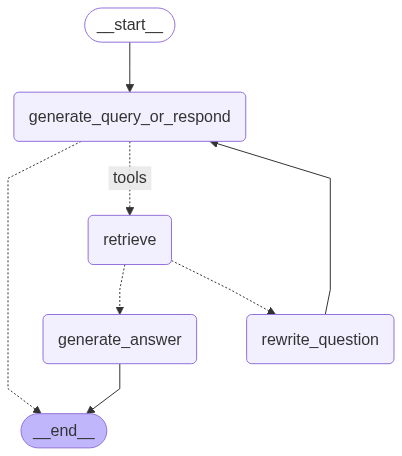

In [34]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

**Executing the Graph**
1. `for chunk in graph.stream(...):`

   * `graph`: This is the compiled `LangGraph` object you built (`workflow.compile()`). It's your complete RAG agent's brain.
   * `.stream(...):` This is a powerful method to execute your graph. Instead of waiting for the entire process to finish, `stream()` yields `"chunks"` of updates as each node in the graph completes its execution. This is incredibly useful for:
     * `Seeing progress`: You can watch the agent `"think"` step by step.
     * `Long-running tasks`: You get feedback incrementally rather than waiting for minutes.
     * `Debugging`: You can pinpoint exactly where the flow goes and what each node outputs.
2. **Initial Input to the Graph:**
```
{
    "messages": [
        {
            "role": "user",
            "content": "What does Lilian Weng say about types of reward hacking?",
        }
    ]
}
```

 * This is the starting `state` you provide to the graph. It's the first message from the user, kicking off the entire process.
 * You've chosen a question that should trigger your RAG capabilities `(tool use, retrieval, grading, etc.).`

3. Outer `for` loop `(for chunk in ...)`:

   * As the `graph` executes, for each node that completes its work and potentially updates the graph's `state`, `graph.stream()` yields a chunk.
   * A `chunk` is typically a dictionary where the keys are the names of the nodes that just executed, and the values are the specific updates those nodes made to the state.
4. Inner `for` loop `(for node, update in chunk.items():)`:
  * This `loop` iterates through the items within each chunk. For a linear flow, a chunk often contains just one node and its update.
  * `node`: This variable will hold the name of the node that just executed (e.g., `"generate_query_or_respond", "retrieve", "generate_answer")`.
  * `update:` This variable holds the actual change to the state made by that node. For nodes that add messages to the conversation history, this update dictionary will look like `{"messages": [new_message]}`
5. `print("Update from node", node):`
  * This simply prints the name of the node that produced the current update, making it easy to follow the flow of execution.
6. `if "messages" in update and update["messages"]::`

   * `Crucial check`: Not every node will necessarily add a new message to the `state["messages"]` list. For example, `grade_documents` returns a string that dictates the next edge, it doesn't add a message. `rewrite_question` does add a message (the rewritten query).
   * This `if` condition ensures that you only try to print the last message if the `update` actually contains a messages key and that `list` is not empty.
   * `update["messages"][-1].pretty_print():`
      * If there's a new message, this accesses the messages list within the `update` dictionary, gets the last (and usually only) new message, and calls its `.pretty_print()` method to display it in a readable format. This lets you see the direct output of each step (e.g., the LLM's decision to call a `tool`, the `tool's` output, the final answer, or a rewritten question).
      * `else: print(f"Node {node} did not add a new message to the state.")`: This handles cases like `grade_documents` where the node's primary output is controlling the graph flow, not adding a message to the history.

7. `print("\n\n"):`

  * Adds some blank lines for visual separation between updates from different nodes, making the output cleaner.


In [35]:
from IPython.display import Image, display

# This loop runs the entire graph workflow
for chunk in graph.stream( # 1. Execute the graph in a streaming fashion
    {
        "messages": [ # 2. Initial input (user's first message)
            {
                "role": "user",
                "content": "What does Lilian Weng say about types of reward hacking?",
            }
        ]
    }
):
    for node, update in chunk.items(): # 3. Iterate through updates from each node
        print("Update from node", node) # 4. Print which node just executed
        # 5. Print the last message added to the state by that node (if any)
        if "messages" in update and update["messages"]: # Check if 'messages' key exists and is not empty
            update["messages"][-1].pretty_print()
        else:
            print(f"Node {node} did not add a new message to the state.") # Explain nodes like grade_documents
        print("\n\n") # For better readability

Update from node generate_query_or_respond
================================== Ai Message ==================================
Tool Calls:
  retrieve_blog_posts (call_3pQJs0a87KU8Q4JC0r6tEnGl)
 Call ID: call_3pQJs0a87KU8Q4JC0r6tEnGl
  Args:
    query: types of reward hacking



Update from node retrieve
================================= Tool Message =================================
Name: retrieve_blog_posts

Detecting Reward Hacking#

In-Context Reward Hacking#

(Note: Some work defines reward tampering as a distinct category of misalignment behavior from reward hacking. But I consider reward hacking as a broader concept here.)
At a high level, reward hacking can be categorized into two types: environment or goal misspecification, and reward tampering.

Why does Reward Hacking Exist?#



Update from node generate_answer
================================== Ai Message ==================================

Lilian Weng categorizes reward hacking into two types: environment or goal misspecificat